In [1]:
import os
import re

import numpy as np

In [2]:
import matplotlib
import matplotlib.pyplot as plt

In [3]:
current_path=os.getcwd()
#result direcory. I assume that I have only one model corresponding to m1. 
res_dir='Processes/m1/Feynman/'


batch_file='batch_file'

#This is an example for the SM. You can modify the code to run in other models, or make it more involved.
model='SM'



def create_process( proc, model ):
    '''
        To create the n_caclhep for a process,  I choose to run a batch for this process once.
        This will create the relevant files for this process in "Processes/m1/Feynman/".
    '''
    with open(batch_file,'w') as _f:
        _f.write('''    
    Model:         {0}
    Model changed: False
    Gauge:         Feynman

    Process:   {1}

    Parallelization mode : local
    Max number of cpus : 8

    nSess_1 : 1
    nCalls_1 : 100
    nSess_2 : 1
    nCalls_2 : 200

    sleep time: 0
    Nice level: 19

        '''.format(model,proc))
        
    return os.system('../calchep_batch '+batch_file)


def run_calchep(process,pcm,mh):
    '''
        Run calchep for a given process for centren-of-mass momentum pcm and higgs mass mh.
        
    '''
    if not os.path.exists(res_dir):
        os.makedirs(res_dir)
        os.system('touch '+res_dir+'processes.txt')

    with open(res_dir+'processes.txt','r') as _f:
        _pf=_f.read()

        
    tmp=re.search(process,_pf)
    if tmp == None:
        print('process not available. running create_process({0},{1})'.format(process,model))
        ch=create_process(process,model)
        if ch!=0:
            print('Process'+ process +'may not exists.')
            os.chdir(current_path)
            return 0,0
            
        with open(res_dir+'processes.txt','r') as _f:
            _pf=_f.read()

        tmp=re.search(process,_pf)

    os.chdir(res_dir+_pf[: tmp.span()[0]  ].split('\n')[-1].split(' ')[0]+'/results')

    
    #this is what you need for calchep! You just have to run these scripts in the directory containing n_calchep!
    os.system('../bin/set_momenta {0} {1}'.format(pcm/2,pcm/2))
    os.system('../bin/set_param Mh {}'.format(mh))
    os.system('../bin/set_vegas 50 1000 50 10000 0')
    result=os.popen('../bin/run_vegas').read()

    
    
    result=result.split(' ')
    
    if len(result)==1:
        csx,err=0,0 
    else:
        csx,err=float(result[0]),float(result[1])
    
    os.chdir(current_path)

    return csx,err/100.



In [4]:
proc='h,h->h,h'
%timeit -n 1 -r 1 print(run_calchep(proc,1000,1))

proc='h,h->h,h,h'
%timeit -n 1 -r 1 print(run_calchep(proc,1000,1))

(9.9615e-09, 4.1199999999999995e-06)
1.32 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
(1.0642e-14, 0.08289999999999999)
5.86 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [5]:
raise KeyboardInterrupt

KeyboardInterrupt: 

In [6]:
proc='h,h->h,h,h'
mh_p = lambda p: np.sqrt(125**2+ 0.5*(p/3.)**2)

csx=[]
err=[]
pcm=[]
for p in np.logspace(0,4,50):
    tmp=run_calchep(proc,pcm=p, mh = mh_p(p))
    pcm.append(p)
    csx.append(tmp[0])
    err.append(tmp[1])

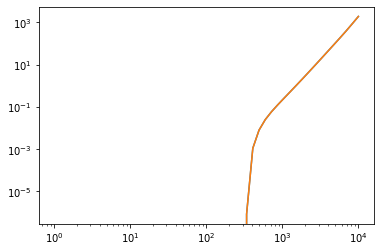

In [7]:
csx=np.array(csx)
err=np.array(err)

fig, ax = plt.subplots()

ax.plot(pcm,csx*(1+err))
ax.plot(pcm,csx*(1-err))

ax.set_xscale('log')
ax.set_yscale('log')

plt.show()